# Ancillary external photometry

This tutorial shows how to use external photometric data to perform astrometry calibrations on a Cube

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from pykoala.data_container import Cube
from pykoala.instruments.koala_ifu import koala_rss

rss = koala_rss("data/27feb20035red.fits")
rss.intensity /= rss.info["exptime"]
rss.variance /= rss.info["exptime"]**2

[pykoala] 2025/10/10 13:21|INFO> 
> Reading KOALA RSS file 27feb20035red.fits
[pykoala] 2025/10/10 13:21|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/10/10 13:21|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]


  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]


In [3]:
from pykoala.corrections.flux_calibration import FluxCalibration

fcal = FluxCalibration.from_text_file('products/response_HILT600_transfer_function.dat')

rss = fcal.apply(rss)

[pykoala.correction.FluxCalibration] 2025/10/10 13:21|INFO> Initialising Flux Calibration (Spectral Throughput)
[pykoala.correction.FluxCalibration] 2025/10/10 13:21|INFO> Interpolating spectral response to input wavelength array


/Users/users/caballero/DATASERVER3/anaconda3/envs/pykoala/lib/python3.13/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


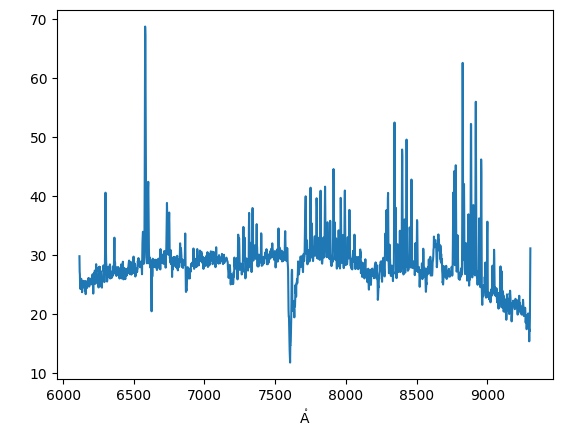

In [4]:
plt.figure()
plt.plot(rss.wavelength, rss.snr[500])

In [ ]:
from pykoala.utils.photometry import query_image, PSQuery

# Query r-band photometry from PS using a cutout with the size of the input cube
# + 30 additional arcseconds on every side. Save the fits in the current working directory
image_query_results = query_image([rss], filters='i', im_extra_size_arcsec=30, im_output_dir='.')

image_query_results = {"PS1.i": {}}
image_query_results["PS1.i"]["ccd"] = PSQuery.read_ps_fits("ps_query_129.0629_n26.4126_i.fits")
image_query_results["PS1.i"]["pix_size"] = PSQuery.pixelsize_arcsec

[pykoala] 2025/10/10 13:24|INFO> Querying image to external database
[pykoala] 2025/10/10 13:24|INFO> Combined footprint Fov: 0.8237094717901527 arcmin, 0.43430455760208986 arcmin


/net/dataserver3/data/users/caballero/KOALA/koala/src/pykoala/photometry.py:745: SyntaxWarning: invalid escape sequence '\D'
  
/net/dataserver3/data/users/caballero/KOALA/koala/src/pykoala/photometry.py:745: SyntaxWarning: invalid escape sequence '\D'
  """Cross-correlate an image with an input set of apertures.


<SkyCoord (ICRS): (ra, dec) in deg
    (129.06331937, -26.4128106)> (<Quantity 0.01372849 deg>, <Quantity 0.00723841 deg>)


UnitConversionError: Can only apply 'add' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

In [ ]:
from pykoala.corrections.astrometry import AstrometryCorrection, compute_offset_from_external_image

corr_offset, results = compute_offset_from_external_image(
    rss, image_query_results["PS1.i"], filter_name="PANSTARRS_PS1.i")

astrom_corr = AstrometricCorrection(offset=corr_offset)


In [ ]:
results["offset_fig"]